In [61]:
import os
import sys
from pathlib import Path

# Data packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics
from sklearn.feature_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import datasets


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
def importData():
    #Import Labelled Data
    DATA_DIR = "Data"
    thispath = Path().absolute()
    #dtype = {"index": str, "title": str, "description": str, "url": str, "date": str, "Retail Relevance": str, "Economy Relevant": str, "Market moving": str}
    RET_ARTICLES = os.path.join(DATA_DIR, "retailarticles-18-11-06.xlsx")

    
    df = pd.read_excel(RET_ARTICLES)

    try:
        df.head()
    except:
        pass
    return df

In [33]:
#def SelectFeaturesNP():
articleDf = importData()

In [34]:
articleDf.columns

Index(['index', 'title', 'description', 'url', 'date', 'content',
       'Retail Relevance', 'Economy Relevant', 'Market moving'],
      dtype='object')

In [35]:
articleDf[['title','content','Market moving']].head()

,title,content,Market moving
0,Rival Retailers Try to Catch a Ride on Amazon ...,"Three years ago, Amazon.com Inc. created a sum...",0
1,Walgreens and AmerisourceBergen deal talks hav...,"The drugstore chain's quarterly profit fell, b...",1
2,Walmart Whistle-Blower Claims Cheating in Race...,In its race to catch Amazon.com Inc. in online...,0
3,Barnes & Noble cuts staff after dismal holiday...,Black Friday shopping has given way to Thanksg...,1
4,Bed Bath & Beyond Tumbles on Signs of Holiday-...,"For Bed Bath &amp; Beyond Inc., Christmas may ...",1


In [18]:
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
tagger = PerceptronTagger()
pos_tag = tagger.tag

In [19]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [20]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [21]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term
            
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [40]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(articleDf, k=1000):
    articles = articleDf['content'].values
    
    # Top-k frequent terms
    counter = Counter()
    for article in tqdm(articles):
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', article)))) 
                            ]))
    topk = counter.most_common(k)    
    allk = counter
    
    #Find out if a particular review has the word from topk list
    freqArticle = []
    for i in tqdm(range(len(articles))):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',articles[i]))))]))
        topkinArticle = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqArticle.append(topkinArticle)
        
        
    #Prepare freqReviewDf
    freqArticleDf = pd.DataFrame(freqArticle)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqArticleDf.columns = dfName
    #finalArticleDf = reviewDF.join(freqReviewDf)
    finaldf = articleDf[['title','content','Market moving']].join(freqArticleDf)
    return topk, finaldf, allk

In [41]:
topk_phrase, articleDf_phrase, allk = newDataFrameTransformation(articleDf)

100%|██████████████████████████████████████████████████████████████████████████████| 2421/2421 [01:06<00:00, 36.40it/s]


In [45]:
articleDf_phrase.head(20)


,title,content,Market moving,last year,central bank,toy u,whole food,interest rate,new york,price target,...,compani spokesman,marc lore,amazon entri,retail consult,execut vice presid,indian compani,onlin market,new one,bain capit kkr,price retail
0,Rival Retailers Try to Catch a Ride on Amazon ...,"Three years ago, Amazon.com Inc. created a sum...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Walgreens and AmerisourceBergen deal talks hav...,"The drugstore chain's quarterly profit fell, b...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Walmart Whistle-Blower Claims Cheating in Race...,In its race to catch Amazon.com Inc. in online...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barnes & Noble cuts staff after dismal holiday...,Black Friday shopping has given way to Thanksg...,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Bed Bath & Beyond Tumbles on Signs of Holiday-...,"For Bed Bath &amp; Beyond Inc., Christmas may ...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Walmart Tries to Lure Millennials With Harry's...,Walmart Inc. will offer men’s grooming product...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Amazon Wants to Get to Teenagers Before the Ba...,Amazon.com Inc. has millennial shoppers nailed...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Kroger Strikes Back at Amazon Go With Expansio...,"Take that, Amazon. Kroger Co., the largest gro...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Bed Bath & Beyond Drops Even as It Gains Groun...,Bed Bath &amp; Beyond Inc. is still on the bri...,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,Amazon Maintains Holiday Dominance Despite Ste...,Amazon.com Inc. maintained its online dominanc...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
def mutualInformation(B_Encoding, y, top_words): 
    #Estimate mutual information for a discrete target variable.
    #Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables.
    #It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
    featureVals= mutual_info_classif(B_Encoding, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    
    np.asarray(featureVals)

    Temp= pd.DataFrame(featureVals, columns = ['MI_Values'])
 
    Final = Temp.assign(target_group = top_words)
    
    Highest_Features = Final.nlargest(250, 'MI_Values')
    
    return Highest_Features

In [81]:
Highest_Features =  mutualInformation(B_Encoding, y, B_Encoding.columns)

In [80]:
B_Encoding = articleDf_phrase
y = articleDf['Retail Relevance']
B_Encoding = articleDf_phrase.drop(['title', 'content', 'Market moving'], axis = 1)
B_Encoding.columns

Index(['last year', 'central bank', 'toy u', 'whole food', 'interest rate',
       'new york', 'price target', 'amazon com inc', 'first child gt',
       'first time',
       ...
       'compani spokesman', 'marc lore', 'amazon entri', 'retail consult',
       'execut vice presid', 'indian compani', 'onlin market', 'new one',
       'bain capit kkr', 'price retail'],
      dtype='object', length=1000)

In [ ]:
B_Encoding.drop(['title', 'content', 'Market moving'], axis = 1)
B_Encoding.head()

In [63]:
Highest_Features

,MI_Values,target_group
1,0.035827,central bank
898,0.030781,market watcher
4,0.030713,interest rate
14,0.029729,walmart inc
424,0.028294,cloud comput
436,0.027737,bond yield
280,0.025405,chine import
769,0.025060,previou month
525,0.025002,low inflat
367,0.024901,current account deficit


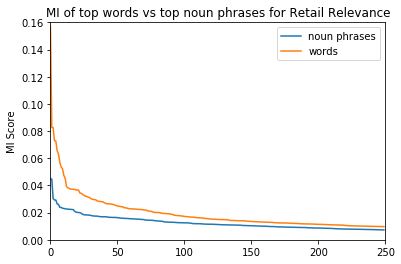

In [83]:
import matplotlib.pyplot as plt
plt.plot(Highest_Features['MI_Values'].values, label = 'noun phrases')
plt.plot(word_MI, label = 'words')
plt.ylabel('MI Score')
plt.axis([0, 250, 0, 0.16])
plt.title('MI of top words vs top noun phrases for Retail Relevance')
plt.legend()
plt.show()


In [68]:
Highest_Features['MI_Values'].values

array([0.03582689, 0.03078141, 0.03071345, 0.02972949, 0.02829353,
       0.02773728, 0.02540522, 0.02506012, 0.0250022 , 0.0249006 ,
       0.02482541, 0.02457954, 0.02450056, 0.02401756, 0.02391275,
       0.02348548, 0.02328169, 0.02234505, 0.02222116, 0.02208814,
       0.02193494, 0.02186092, 0.02158014, 0.02128537, 0.02110182,
       0.02100443, 0.02083943, 0.02060274, 0.02045371, 0.02040852,
       0.02039672, 0.02039458, 0.02024429, 0.02023627, 0.02012499,
       0.01969376, 0.01963616, 0.01957684, 0.01954159, 0.01943286,
       0.01923137, 0.01921258, 0.01907623, 0.01902918, 0.01883923,
       0.01880408, 0.01853849, 0.01853705, 0.01825464, 0.01817542,
       0.01815657, 0.01806942, 0.01802764, 0.01777944, 0.0176301 ,
       0.01746185, 0.01722335, 0.0170454 , 0.01700797, 0.01700547,
       0.01700389, 0.01699174, 0.01685488, 0.01676592, 0.01675373,
       0.01641217, 0.01596929, 0.01594269, 0.01590508, 0.01582538,
       0.01563435, 0.01557209, 0.01555124, 0.01549767, 0.01544

In [71]:
word_MI = [0.15685016, 0.08263148, 0.08260702, 0.07286888, 0.0727404 , 
       0.0654984 , 0.06318497, 0.05706316, 0.05342845, 0.05229887,
       0.04736192, 0.04527032, 0.03910597, 0.0382909 , 0.03785268,
       0.03732769, 0.03720455, 0.03714783, 0.0370412 , 0.03674766,
       0.03660287, 0.0365798 , 0.03439267, 0.03418774, 0.03344898,
       0.0327996 , 0.03204193, 0.03201651, 0.03143229, 0.0311371 ,
       0.03046653, 0.02992761, 0.02967316, 0.02956049, 0.02928386,
       0.02852677, 0.0283682 , 0.02813763, 0.02805806, 0.02797806,
       0.0274677 , 0.02681647, 0.02657687, 0.02647535, 0.02632202,
       0.02631743, 0.02626254, 0.02589552, 0.02561664, 0.02521897,
       0.02488037, 0.02471711, 0.02451793, 0.0243018 , 0.02428727,
       0.02358891, 0.02354837, 0.02335415, 0.02304278, 0.0228199 ,
       0.02278789, 0.02273341, 0.02271051, 0.02265611, 0.0225839 ,
       0.02241316, 0.02238736, 0.02237391, 0.02223753, 0.02202336,
       0.02195768, 0.02182063, 0.02170697, 0.02108735, 0.02104781,
       0.02101601, 0.0206972 , 0.02022249, 0.02014468, 0.02009752,
       0.02003192, 0.02002081, 0.01992059, 0.01953753, 0.01944085,
       0.01932953, 0.01925128, 0.01921858, 0.019177  , 0.01912073,
       0.01878469, 0.01876031, 0.01819669, 0.01800605, 0.01788864,
       0.01781546, 0.01769696, 0.01766886, 0.01748472, 0.01745597,
       0.01719029, 0.0171628 , 0.01707625, 0.01687403, 0.01678298,
       0.01665261, 0.01659525, 0.01657155, 0.01654005, 0.0162773 ,
       0.01623894, 0.01621432, 0.01614828, 0.01606001, 0.01601459,
       0.01575246, 0.01573945, 0.0155525 , 0.01543243, 0.01542022,
       0.01526572, 0.0152326 , 0.0151825 , 0.01513105, 0.01506344,
       0.0149539 , 0.01493832, 0.01484681, 0.01483643, 0.01483036,
       0.01482964, 0.01482309, 0.01467814, 0.01467538, 0.01423805,
       0.01423566, 0.01422611, 0.0141962 , 0.01415151, 0.01413871,
       0.01409401, 0.01404255, 0.01401697, 0.01398029, 0.01395775,
       0.01395582, 0.01380354, 0.01368303, 0.01361411, 0.01346405,
       0.01345424, 0.01341171, 0.01336537, 0.01329642, 0.01328845,
       0.013248  , 0.01316324, 0.01312931, 0.01309673, 0.01307972,
       0.01304401, 0.01300114, 0.01297728, 0.01294217, 0.01293249,
       0.01292157, 0.01277577, 0.01261388, 0.01255833, 0.01254013,
       0.01252586, 0.01242572, 0.0124206 , 0.01240847, 0.01239289,
       0.01238173, 0.0123756 , 0.0123511 , 0.01221895, 0.01221107,
       0.01220684, 0.01210398, 0.01208601, 0.01207174, 0.01204127,
       0.01190933, 0.01189506, 0.01182776, 0.01175428, 0.0117343 ,
       0.01170031, 0.01169628, 0.01168227, 0.01166558, 0.01163642,
       0.01161614, 0.01158428, 0.01153784, 0.01143798, 0.01142473,
       0.01141251, 0.01137744, 0.01136863, 0.01135992, 0.01128695,
       0.01122754, 0.011183  , 0.0111815 , 0.01110504, 0.01104444,
       0.01101577, 0.01101385, 0.01094865, 0.01088758, 0.01088383,
       0.01086328, 0.01084084, 0.01080057, 0.01077004, 0.01076268,
       0.01054403, 0.01047498, 0.0103773 , 0.01036865, 0.01030642,
       0.01027068, 0.01024832, 0.01024157, 0.01018221, 0.01017854,
       0.01015532, 0.01009939, 0.01008728, 0.01008393, 0.01007949,
       0.01001573, 0.00997922, 0.0099745 , 0.00996542, 0.00994597,
       0.00993376, 0.00992274, 0.00990525, 0.00982821, 0.00980088,
       0.00976811, 0.00973395, 0.00972009, 0.00971938, 0.00969105]

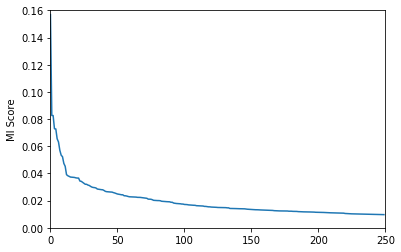

In [74]:
import matplotlib.pyplot as plt
plt.plot(word_MI)
plt.ylabel('MI Score')
plt.axis([0, 250, 0, 0.16])
plt.show()

In [85]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [109]:
doc = nlp('European authorities fined Google and Banana Republic and Microsoft a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('Banana Republic', 'GPE'), ('Microsoft', 'ORG'), ('a record $5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [110]:
print(doc.ents)

(European, Google, Banana Republic, Microsoft, a record $5.1 billion, Wednesday)


In [106]:
orgs = filter(lambda X: X.label_ =='ORG', doc.ents)
list(orgs)

[Google, Microsoft]